# Multiple Linear Regression Model #

### Time Series Regression Explaining Stock's Returns ###

In [145]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t

# Pretty Notation
from IPython.display import display, Math

In [146]:
# The Matrix Form of the OLS Linear Regression Model

display(Math(r"Y = X\beta+\varepsilon"))

<IPython.core.display.Math object>

In [147]:
# Data S&P500

sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500.set_index('Date', inplace = True)
sp500.index = pd.to_datetime(sp500.index)
sp500.dropna(inplace = True)

# Cut the sample
sp500 = sp500.loc['2015-01-01':]

sp500

SP500
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893
...                 ...
2024-12-24  6040.040039
2024-12-26  6037.589844
2024-12-27  5970.839844
2024-12-30  5906.939941
2024-12-31  5881.629883

[2516 rows x 1 columns]

In [148]:
# Call the stock's data

data_stock = pd.read_csv(rf"..\stocks\AMZN.csv")
data_stock.set_index('Date', inplace = True)
data_stock.index = pd.to_datetime(data_stock.index)
data_stock.dropna(inplace = True)

# Cut the sample
data_stock = data_stock.loc['2015-01-01':]

data_stock

Instrument  Open Price  High Price  Low Price  Close Price  \
Date                                                                    
2015-01-02    AMZN.OQ     15.6290     15.7375    15.3485      15.4260   
2015-01-05    AMZN.OQ     15.3505     15.4190    15.0425      15.1095   
2015-01-06    AMZN.OQ     15.1120     15.1270    14.6210      14.7645   
2015-01-07    AMZN.OQ     14.8750     15.0640    14.7670      14.9210   
2015-01-08    AMZN.OQ     15.0160     15.1570    14.8075      15.0230   
...               ...         ...         ...        ...          ...   
2024-10-15    AMZN.OQ    187.5400    188.4100   184.5900     187.6900   
2024-10-16    AMZN.OQ    187.0600    187.7700   185.6150     186.8900   
2024-10-17    AMZN.OQ    188.1900    188.9400   186.0000     187.5300   
2024-10-18    AMZN.OQ    187.1100    190.7400   186.3000     188.9900   
2024-10-21    AMZN.OQ    188.0000    189.4600   186.4000     189.0700   

            Adjusted_close      Volume  Company Market Cap  \
Date                                                         
2015-01-02         15.4260  14932119.0        1.380724e+11   
2015-01-05         15.1095  21538739.0        1.355056e+11   
2015-01-06         14.7645  26109759.0        1.370541e+11   
2015-01-07         14.9210  31914019.0        1.363705e+11   
2015-01-08         15.0230  29392639.0        1.334318e+11   
...                    ...         ...                 ...   
2024-10-15        187.6900   9804437.0        1.991009e+12   
2024-10-16        186.8900   9654994.0        1.938636e+12   
2024-10-17        187.5300   6480613.0        1.956164e+12   
2024-10-18        188.9900   9893488.0        1.971382e+12   
2024-10-21        189.0700   7163532.0        1.977260e+12   

            Average Number of Shares Outstanding  Book Value per Share  ...  \
Date                                                                    ...   
2015-01-02                          9.260000e+09              1.116199  ...   
2015-01-05                          9.260000e+09              1.116199  ...   
2015-01-06                          9.260000e+09              1.116199  ...   
2015-01-07                          9.260000e+09              1.116199  ...   
2015-01-08                          9.260000e+09              1.116199  ...   
...                                          ...                   ...  ...   
2024-10-15                          1.070800e+10             22.540229  ...   
2024-10-16                          1.070800e+10             22.540229  ...   
2024-10-17                          1.070800e+10             22.540229  ...   
2024-10-18                          1.070800e+10             22.540229  ...   
2024-10-21                          1.070800e+10             22.540229  ...   

            Shares used to calculate Basic EPS - Total  T12M_Revenue  \
Date                                                                   
2015-01-02                                9.260000e+09  8.524700e+10   
2015-01-05                                9.260000e+09  8.524700e+10   
2015-01-06                                9.260000e+09  8.524700e+10   
2015-01-07                                9.260000e+09  8.524700e+10   
2015-01-08                                9.260000e+09  8.524700e+10   
...                                                ...           ...   
2024-10-15                                1.044700e+10  6.043340e+11   
2024-10-16                                1.044700e+10  6.043340e+11   
2024-10-17                                1.044700e+10  6.043340e+11   
2024-10-18                                1.044700e+10  6.043340e+11   
2024-10-21                                1.044700e+10  6.043340e+11   

            T12M_Net_Income  Announce_Date Market_cap_calculado  \
Date                                                              
2015-01-02    -2.150000e+08     2014-10-23         1.428448e+11   
2015-01-05    -2.150000e+08     2014-10-23         1.399140e+11   
2015-01-06    -2.1500

In [149]:
# Create the Data we will need

data_regression = pd.DataFrame(index=data_stock.index)

# Now safely add new columns
data_regression['returns'] = data_stock['Adjusted_close'].pct_change(1).mul(100)
data_regression['mkt_returns'] = sp500.pct_change(1).mul(100)
data_regression['log_mktcap'] = np.log(data_stock['Company Market Cap'])
data_regression['annualized_volat'] = data_regression['returns'].rolling(window=252).std() * np.sqrt(252)
data_regression['ptb'] = data_stock['Price_to_Book']

# Drop nans
data_regression.dropna(inplace = True)

data_regression

returns  mkt_returns  log_mktcap  annualized_volat        ptb
Date                                                                      
2016-01-04 -5.755374    -1.530373   26.391673         34.105853  24.034458
2016-01-05 -0.502363     0.201223   26.391916         34.033236  23.913718
2016-01-06 -0.179870    -1.311540   26.331750         33.936779  23.870704
2016-01-07 -3.905793    -2.370044   26.350800         34.191133  22.938364
2016-01-08 -0.146396    -1.083837   26.311558         34.191983  22.904783
...              ...          ...         ...               ...        ...
2024-10-15  0.079983    -0.760947   28.319663         27.849236   8.326890
2024-10-16 -0.426235     0.467915   28.293006         27.785351   8.291398
2024-10-17  0.342447    -0.017116   28.302006         27.769032   8.319791
2024-10-18  0.778542     0.397155   28.309756         27.643488   8.384564
2024-10-21  0.042330    -0.182277   28.312733         27.643748   8.388114

[2215 rows x 5 columns]

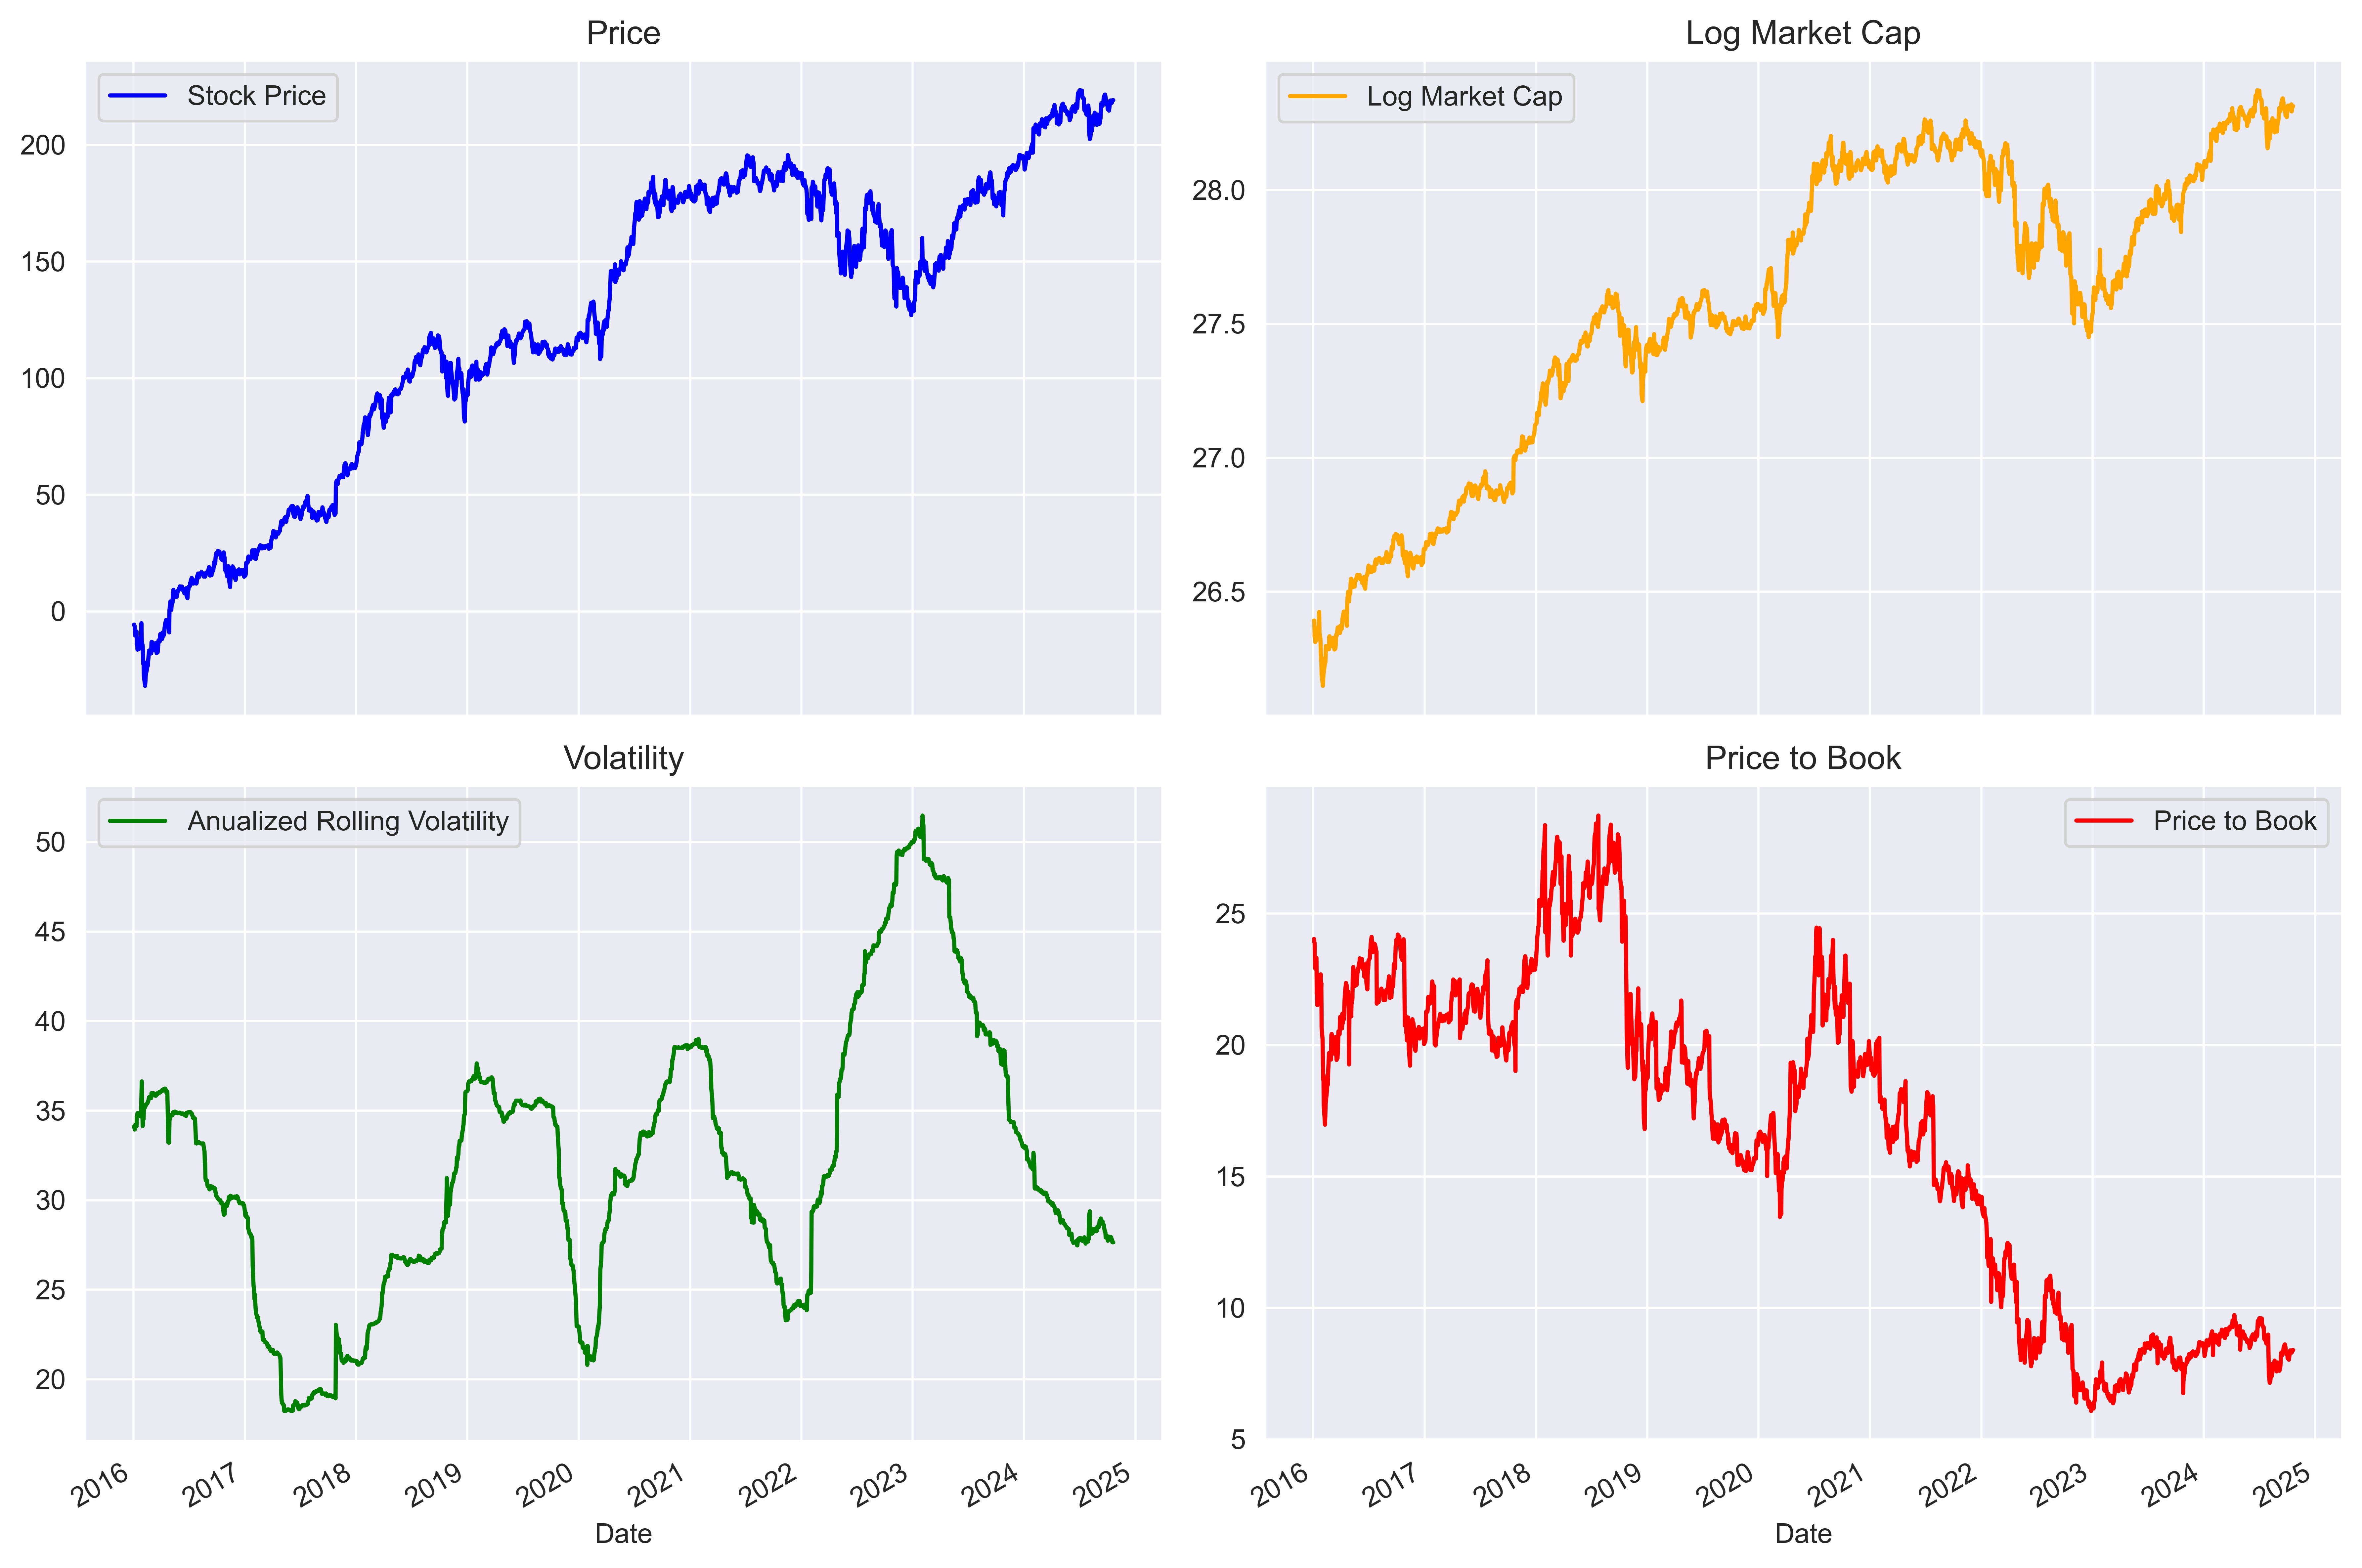

In [150]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600, sharex=True)  # 2 filas, 2 columnas

# First Graph
data_regression['returns'].cumsum().plot(ax=axs[0, 0], color='blue', label='Stock Price')
axs[0, 0].set_title('Price')
axs[0, 0].legend()

# Second Graph
data_regression['log_mktcap'].plot(ax=axs[0, 1], color='orange', label='Log Market Cap')
axs[0, 1].set_title('Log Market Cap')
axs[0, 1].legend()

# Third Graph
data_regression['annualized_volat'].plot(ax=axs[1, 0], color='green', label='Anualized Rolling Volatility')
axs[1, 0].set_title('Volatility')
axs[1, 0].legend()

# Fourth
data_regression['ptb'].plot(ax=axs[1, 1], color='red', label='Price to Book')
axs[1, 1].set_title('Price to Book')
axs[1, 1].legend()

# Show
plt.tight_layout()
plt.show()

In [151]:
# Correlation Matrix

data_regression.corr()

returns  mkt_returns  log_mktcap  annualized_volat  \
returns           1.000000     0.636651    0.006422         -0.010797   
mkt_returns       0.636651     1.000000    0.019289          0.012169   
log_mktcap        0.006422     0.019289    1.000000          0.218701   
annualized_volat -0.010797     0.012169    0.218701          1.000000   
ptb               0.042797     0.016401   -0.563751         -0.523154   

                       ptb  
returns           0.042797  
mkt_returns       0.016401  
log_mktcap       -0.563751  
annualized_volat -0.523154  
ptb               1.000000

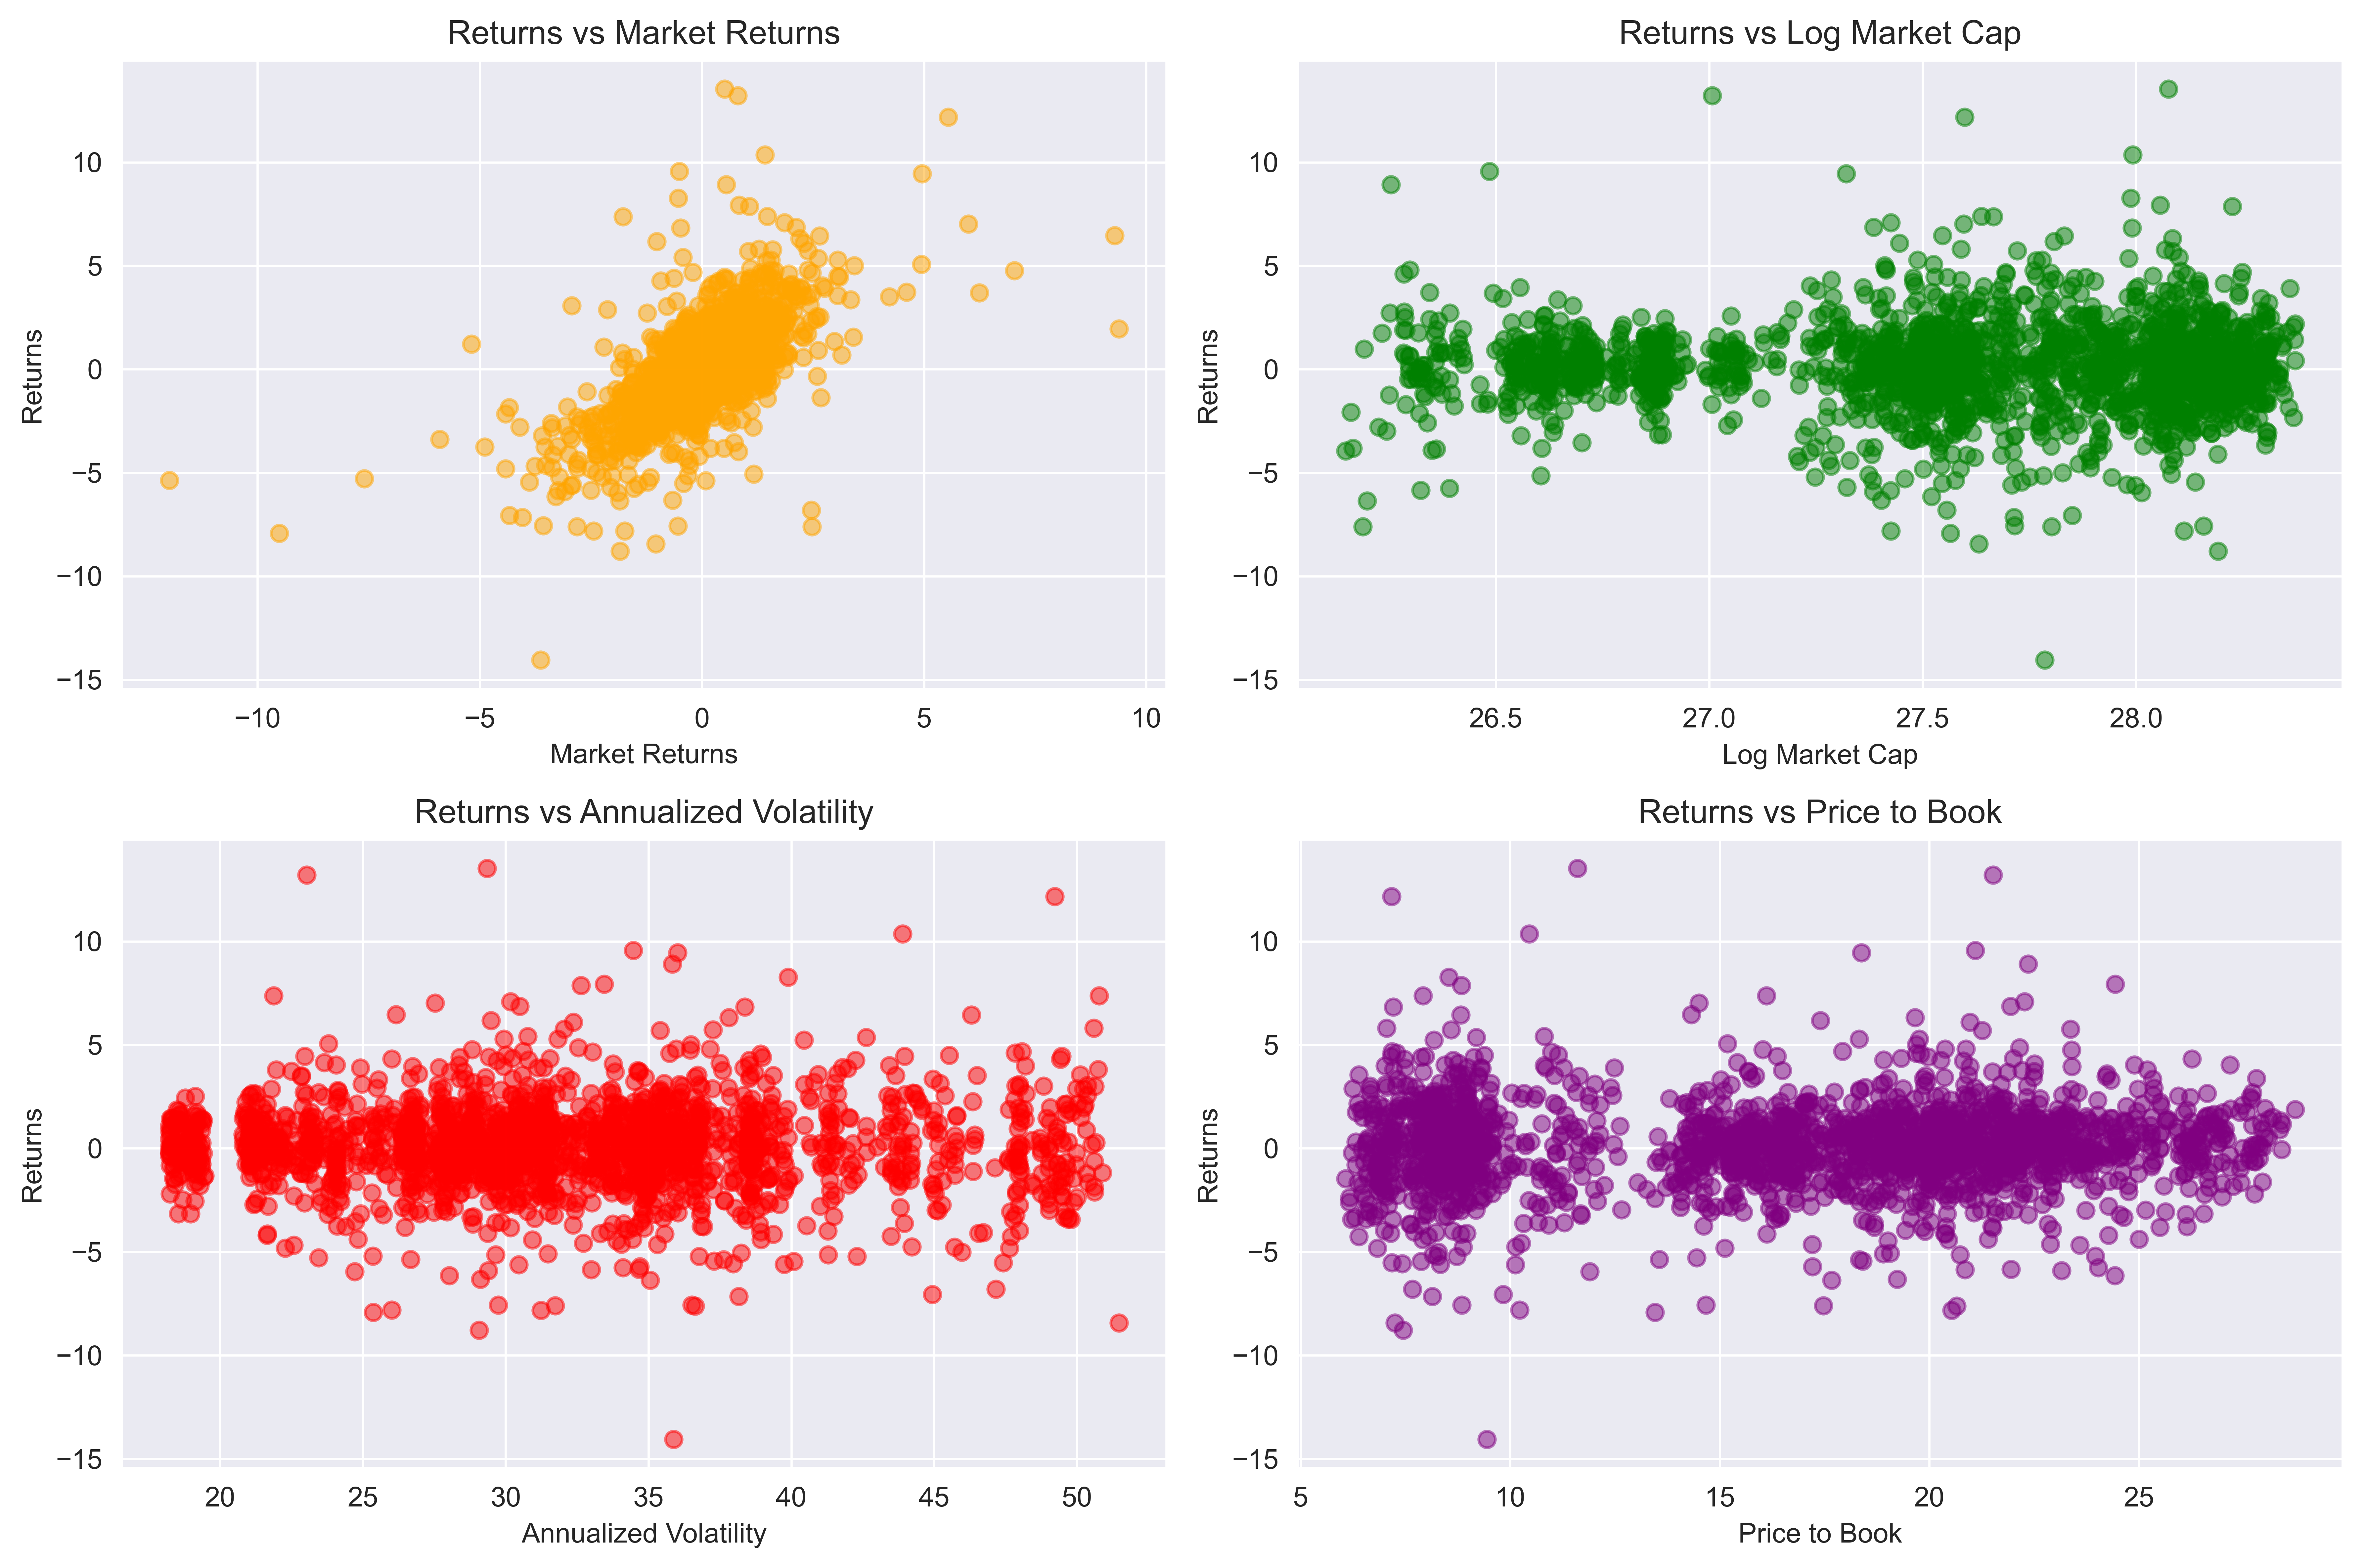

In [152]:

# Setup subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600)

# Variables to plot against 'returns'
variables = ['mkt_returns', 'log_mktcap', 'annualized_volat', 'ptb']
titles = ['Market Returns', 'Log Market Cap', 'Annualized Volatility', 'Price to Book']
colors = ['orange', 'green', 'red', 'purple']

# Create scatter plots
for i, (var, title, color) in enumerate(zip(variables, titles, colors)):
    row, col = divmod(i, 2)
    axs[row, col].scatter(data_regression[var], data_regression['returns'], alpha=0.5, color=color)
    axs[row, col].set_title(f'Returns vs {title}')
    axs[row, col].set_xlabel(title)
    axs[row, col].set_ylabel('Returns')

# Layout and show
plt.tight_layout()
plt.show()

In [153]:
filtered_data = data_regression[(np.abs(data_regression - data_regression.mean()) <= 3 * data_regression.std())]

filtered_data.dropna(inplace = True)

filtered_data

returns  mkt_returns  log_mktcap  annualized_volat        ptb
Date                                                                      
2016-01-04 -5.755374    -1.530373   26.391673         34.105853  24.034458
2016-01-05 -0.502363     0.201223   26.391916         34.033236  23.913718
2016-01-06 -0.179870    -1.311540   26.331750         33.936779  23.870704
2016-01-07 -3.905793    -2.370044   26.350800         34.191133  22.938364
2016-01-08 -0.146396    -1.083837   26.311558         34.191983  22.904783
...              ...          ...         ...               ...        ...
2024-10-15  0.079983    -0.760947   28.319663         27.849236   8.326890
2024-10-16 -0.426235     0.467915   28.293006         27.785351   8.291398
2024-10-17  0.342447    -0.017116   28.302006         27.769032   8.319791
2024-10-18  0.778542     0.397155   28.309756         27.643488   8.384564
2024-10-21  0.042330    -0.182277   28.312733         27.643748   8.388114

[2159 rows x 5 columns]

In [154]:
# The Correlation Matrix

filtered_data.corr()

returns  mkt_returns  log_mktcap  annualized_volat  \
returns           1.000000     0.669124    0.008951         -0.019317   
mkt_returns       0.669124     1.000000    0.028261         -0.000899   
log_mktcap        0.008951     0.028261    1.000000          0.221884   
annualized_volat -0.019317    -0.000899    0.221884          1.000000   
ptb               0.045748     0.018983   -0.566364         -0.525052   

                       ptb  
returns           0.045748  
mkt_returns       0.018983  
log_mktcap       -0.566364  
annualized_volat -0.525052  
ptb               1.000000

In [155]:
# Create the Y Vector

Y_Vector = filtered_data["returns"]

Y_Vector

Date
2016-01-04   -5.755374
2016-01-05   -0.502363
2016-01-06   -0.179870
2016-01-07   -3.905793
2016-01-08   -0.146396
                ...   
2024-10-15    0.079983
2024-10-16   -0.426235
2024-10-17    0.342447
2024-10-18    0.778542
2024-10-21    0.042330
Name: returns, Length: 2159, dtype: float64

In [156]:
# Create the Information Matrix
# Remember to add a constant
filtered_data['squared_volat'] = filtered_data['annualized_volat'].mul(filtered_data['annualized_volat'])

Information_Matrix = filtered_data.copy().drop('returns', axis=1)
Information_Matrix = sm.add_constant(Information_Matrix)

Information_Matrix

const  mkt_returns  log_mktcap  annualized_volat        ptb  \
Date                                                                      
2016-01-04    1.0    -1.530373   26.391673         34.105853  24.034458   
2016-01-05    1.0     0.201223   26.391916         34.033236  23.913718   
2016-01-06    1.0    -1.311540   26.331750         33.936779  23.870704   
2016-01-07    1.0    -2.370044   26.350800         34.191133  22.938364   
2016-01-08    1.0    -1.083837   26.311558         34.191983  22.904783   
...           ...          ...         ...               ...        ...   
2024-10-15    1.0    -0.760947   28.319663         27.849236   8.326890   
2024-10-16    1.0     0.467915   28.293006         27.785351   8.291398   
2024-10-17    1.0    -0.017116   28.302006         27.769032   8.319791   
2024-10-18    1.0     0.397155   28.309756         27.643488   8.384564   
2024-10-21    1.0    -0.182277   28.312733         27.643748   8.388114   

            squared_volat  
Date                       
2016-01-04    1163.209210  
2016-01-05    1158.261176  
2016-01-06    1151.704937  
2016-01-07    1169.033571  
2016-01-08    1169.091693  
...                   ...  
2024-10-15     775.579946  
2024-10-16     772.025749  
2024-10-17     771.119160  
2024-10-18     764.162429  
2024-10-21     764.176829  

[2159 rows x 6 columns]

In [157]:
# For estimating the coefficients with the OLS we need to assess the non-perfect collinearity condition with the matrix rank

Rank = np.linalg.matrix_rank(Information_Matrix)

# Since we are estimating four betas, the rank must be the number of columns in the Information Matrix

if Rank == 6:
    print(f"Matrix Rank is {Rank}; there is no evidence of Perfect Multicollinearity.")
else:
    print(f"Matrix Rank is {Rank}; there is evidence of Perfect Multicollinearity between two or more variables.")

Matrix Rank is 6; there is no evidence of Perfect Multicollinearity.


In [158]:
# The beta calculation in the Matrix Form

display(Math(r"\beta=(X^⊤X)^{-1}(X^⊤Y)"))

# The vector of betas is a kx1 vector containing the coefficients of the regression model, where k is the number of parameters to estimate

<IPython.core.display.Math object>

In [159]:
# Transpose of the Information Matrix

Information_Matrix_T = Information_Matrix.transpose()

Information_Matrix_T

Date               2016-01-04   2016-01-05   2016-01-06   2016-01-07  \
const                1.000000     1.000000     1.000000     1.000000   
mkt_returns         -1.530373     0.201223    -1.311540    -2.370044   
log_mktcap          26.391673    26.391916    26.331750    26.350800   
annualized_volat    34.105853    34.033236    33.936779    34.191133   
ptb                 24.034458    23.913718    23.870704    22.938364   
squared_volat     1163.209210  1158.261176  1151.704937  1169.033571   

Date               2016-01-08   2016-01-11   2016-01-12   2016-01-13  \
const                1.000000     1.000000     1.000000     1.000000   
mkt_returns         -1.083837     0.085327     0.780280    -2.496545   
log_mktcap          26.311558    26.319071    26.318770    26.324438   
annualized_volat    34.191983    34.190724    34.122381    34.663579   
ptb                 22.904783    23.308130    23.313790    21.952445   
squared_volat     1169.091693  1169.005625  1164.336886  1201.563691   

Date               2016-01-14   2016-01-15  ...  2024-10-08  2024-10-09  \
const                1.000000     1.000000  ...    1.000000    1.000000   
mkt_returns          1.669591    -2.159910  ...    0.968935    0.711341   
log_mktcap          26.360911    26.361163  ...   28.309010   28.304739   
annualized_volat    34.692625    34.854007  ...   27.925275   27.950267   
ptb                 22.374658    21.513630  ...    8.106395    8.215090   
squared_volat     1203.578254  1214.801825  ...  779.820961  781.217419   

Date              2024-10-10  2024-10-11  2024-10-14  2024-10-15  2024-10-16  \
const               1.000000    1.000000    1.000000    1.000000    1.000000   
mkt_returns        -0.207012    0.605185    0.770767   -0.760947    0.467915   
log_mktcap         28.308158   28.315913   28.316336   28.319663   28.293006   
annualized_volat   27.946369   27.915195   27.926801   27.849236   27.785351   
ptb                 8.280750    8.377022    8.320235    8.326890    8.291398   
squared_volat     780.999522  779.258137  779.906190  775.579946  772.025749   

Date              2024-10-17  2024-10-18  2024-10-21  
const               1.000000    1.000000    1.000000  
mkt_returns        -0.017116    0.397155   -0.182277  
log_mktcap         28.302006   28.309756   28.312733  
annualized_volat   27.769032   27.643488   27.643748  
ptb                 8.319791    8.384564    8.388114  
squared_volat     771.119160  764.162429  764.176829  

[6 rows x 2159 columns]

In [160]:
# Now we have to calculate the (X^⊤X)^{-1}, first the square of the Information Matrix

Information_Matrix_Square = Information_Matrix_T.dot(Information_Matrix)

# We could also use the command Information_Matrix_T @ Information_Matrix

Information_Matrix_Square

const    mkt_returns    log_mktcap  annualized_volat  \
const             2.159000e+03     156.152434  5.953895e+04      6.916315e+04   
mkt_returns       1.561524e+02    1815.907730  4.337768e+03      4.988799e+03   
log_mktcap        5.953895e+04    4337.768216  1.642601e+06      1.909380e+06   
annualized_volat  6.916315e+04    4988.799415  1.909380e+06      2.340727e+06   
ptb               3.584502e+04    2822.690433  9.842552e+05      1.095288e+06   
squared_volat     2.340727e+06  164987.486760  6.467043e+07      8.332332e+07   

                           ptb  squared_volat  
const             3.584502e+04   2.340727e+06  
mkt_returns       2.822690e+03   1.649875e+05  
log_mktcap        9.842552e+05   6.467043e+07  
annualized_volat  1.095288e+06   8.332332e+07  
ptb               6.765725e+05   3.517357e+07  
squared_volat     3.517357e+07   3.105634e+09

In [161]:
# The reason we needed to know the rank of the information matrix is because, only full rank matrix can be invertible
# Then we can calculate the Matrix Determinant, if it is different from zero, we can calculate the OLS coefficients

Information_Matrix_Square_Determinant = np.linalg.det(Information_Matrix_Square)

if Information_Matrix_Square_Determinant != 0:
    print(f"The Determinant of the Squared Information Matrix is {Information_Matrix_Square_Determinant} and different from zero")
else:
    print("Matrix NOT invertible")

The Determinant of the Squared Information Matrix is 1.3496965426416423e+26 and different from zero


In [162]:
# Now we have to obtain the Inverse Matrix

X_Variance_Matrix_Inverse = np.linalg.inv(Information_Matrix_Square)

X_Variance_Matrix_Inverse

array([[ 1.85912872e+00,  1.55055803e-03, -6.59819994e-02,
         3.30553551e-03, -4.46232424e-03, -6.54802261e-05],
       [ 1.55055803e-03,  5.55722469e-04, -5.26203768e-05,
        -2.23978929e-06, -5.08200345e-06,  1.52111088e-08],
       [-6.59819994e-02, -5.26203768e-05,  2.48203815e-03,
        -3.47622724e-04,  1.56878156e-04,  5.59859971e-06],
       [ 3.30553551e-03, -2.23978929e-06, -3.47622724e-04,
         4.28254407e-04, -2.96042685e-05, -6.40718295e-06],
       [-4.46232424e-03, -5.08200345e-06,  1.56878156e-04,
        -2.96042685e-05,  2.74692077e-05,  5.79940021e-07],
       [-6.54802261e-05,  1.52111088e-08,  5.59859971e-06,
        -6.40718295e-06,  5.79940021e-07,  9.84256838e-08]])

In [163]:
# Now we have to obtain (X^⊤Y)

Y_Covariance_X = Information_Matrix_T.dot(Y_Vector)

Y_Covariance_X

const                  210.878287
mkt_returns           2316.756161
log_mktcap            5834.448408
annualized_volat      6202.258060
ptb                   4558.285539
squared_volat       189653.862471
dtype: float64

In [164]:
# Now we can calculate the Betas

Beta = X_Variance_Matrix_Inverse.dot(Y_Covariance_X)

Beta_DF = pd.DataFrame(Beta, index = Information_Matrix.columns)
Beta_DF

0
const            -1.583768
mkt_returns       1.273269
log_mktcap        0.066090
annualized_volat -0.030258
ptb               0.014103
squared_volat     0.000463

In [165]:
# Now we can obtain the fitted values

Y_Hat = Information_Matrix.dot(Beta)

Y_Hat

Date
2016-01-04   -1.942596
2016-01-05    0.260411
2016-01-06   -1.670443
2016-01-07   -3.029768
2016-01-08   -1.395146
                ...   
2024-10-15   -1.047169
2024-10-16    0.515527
2024-10-17   -0.100978
2024-10-18    0.428505
2024-10-21   -0.309023
Length: 2159, dtype: float64

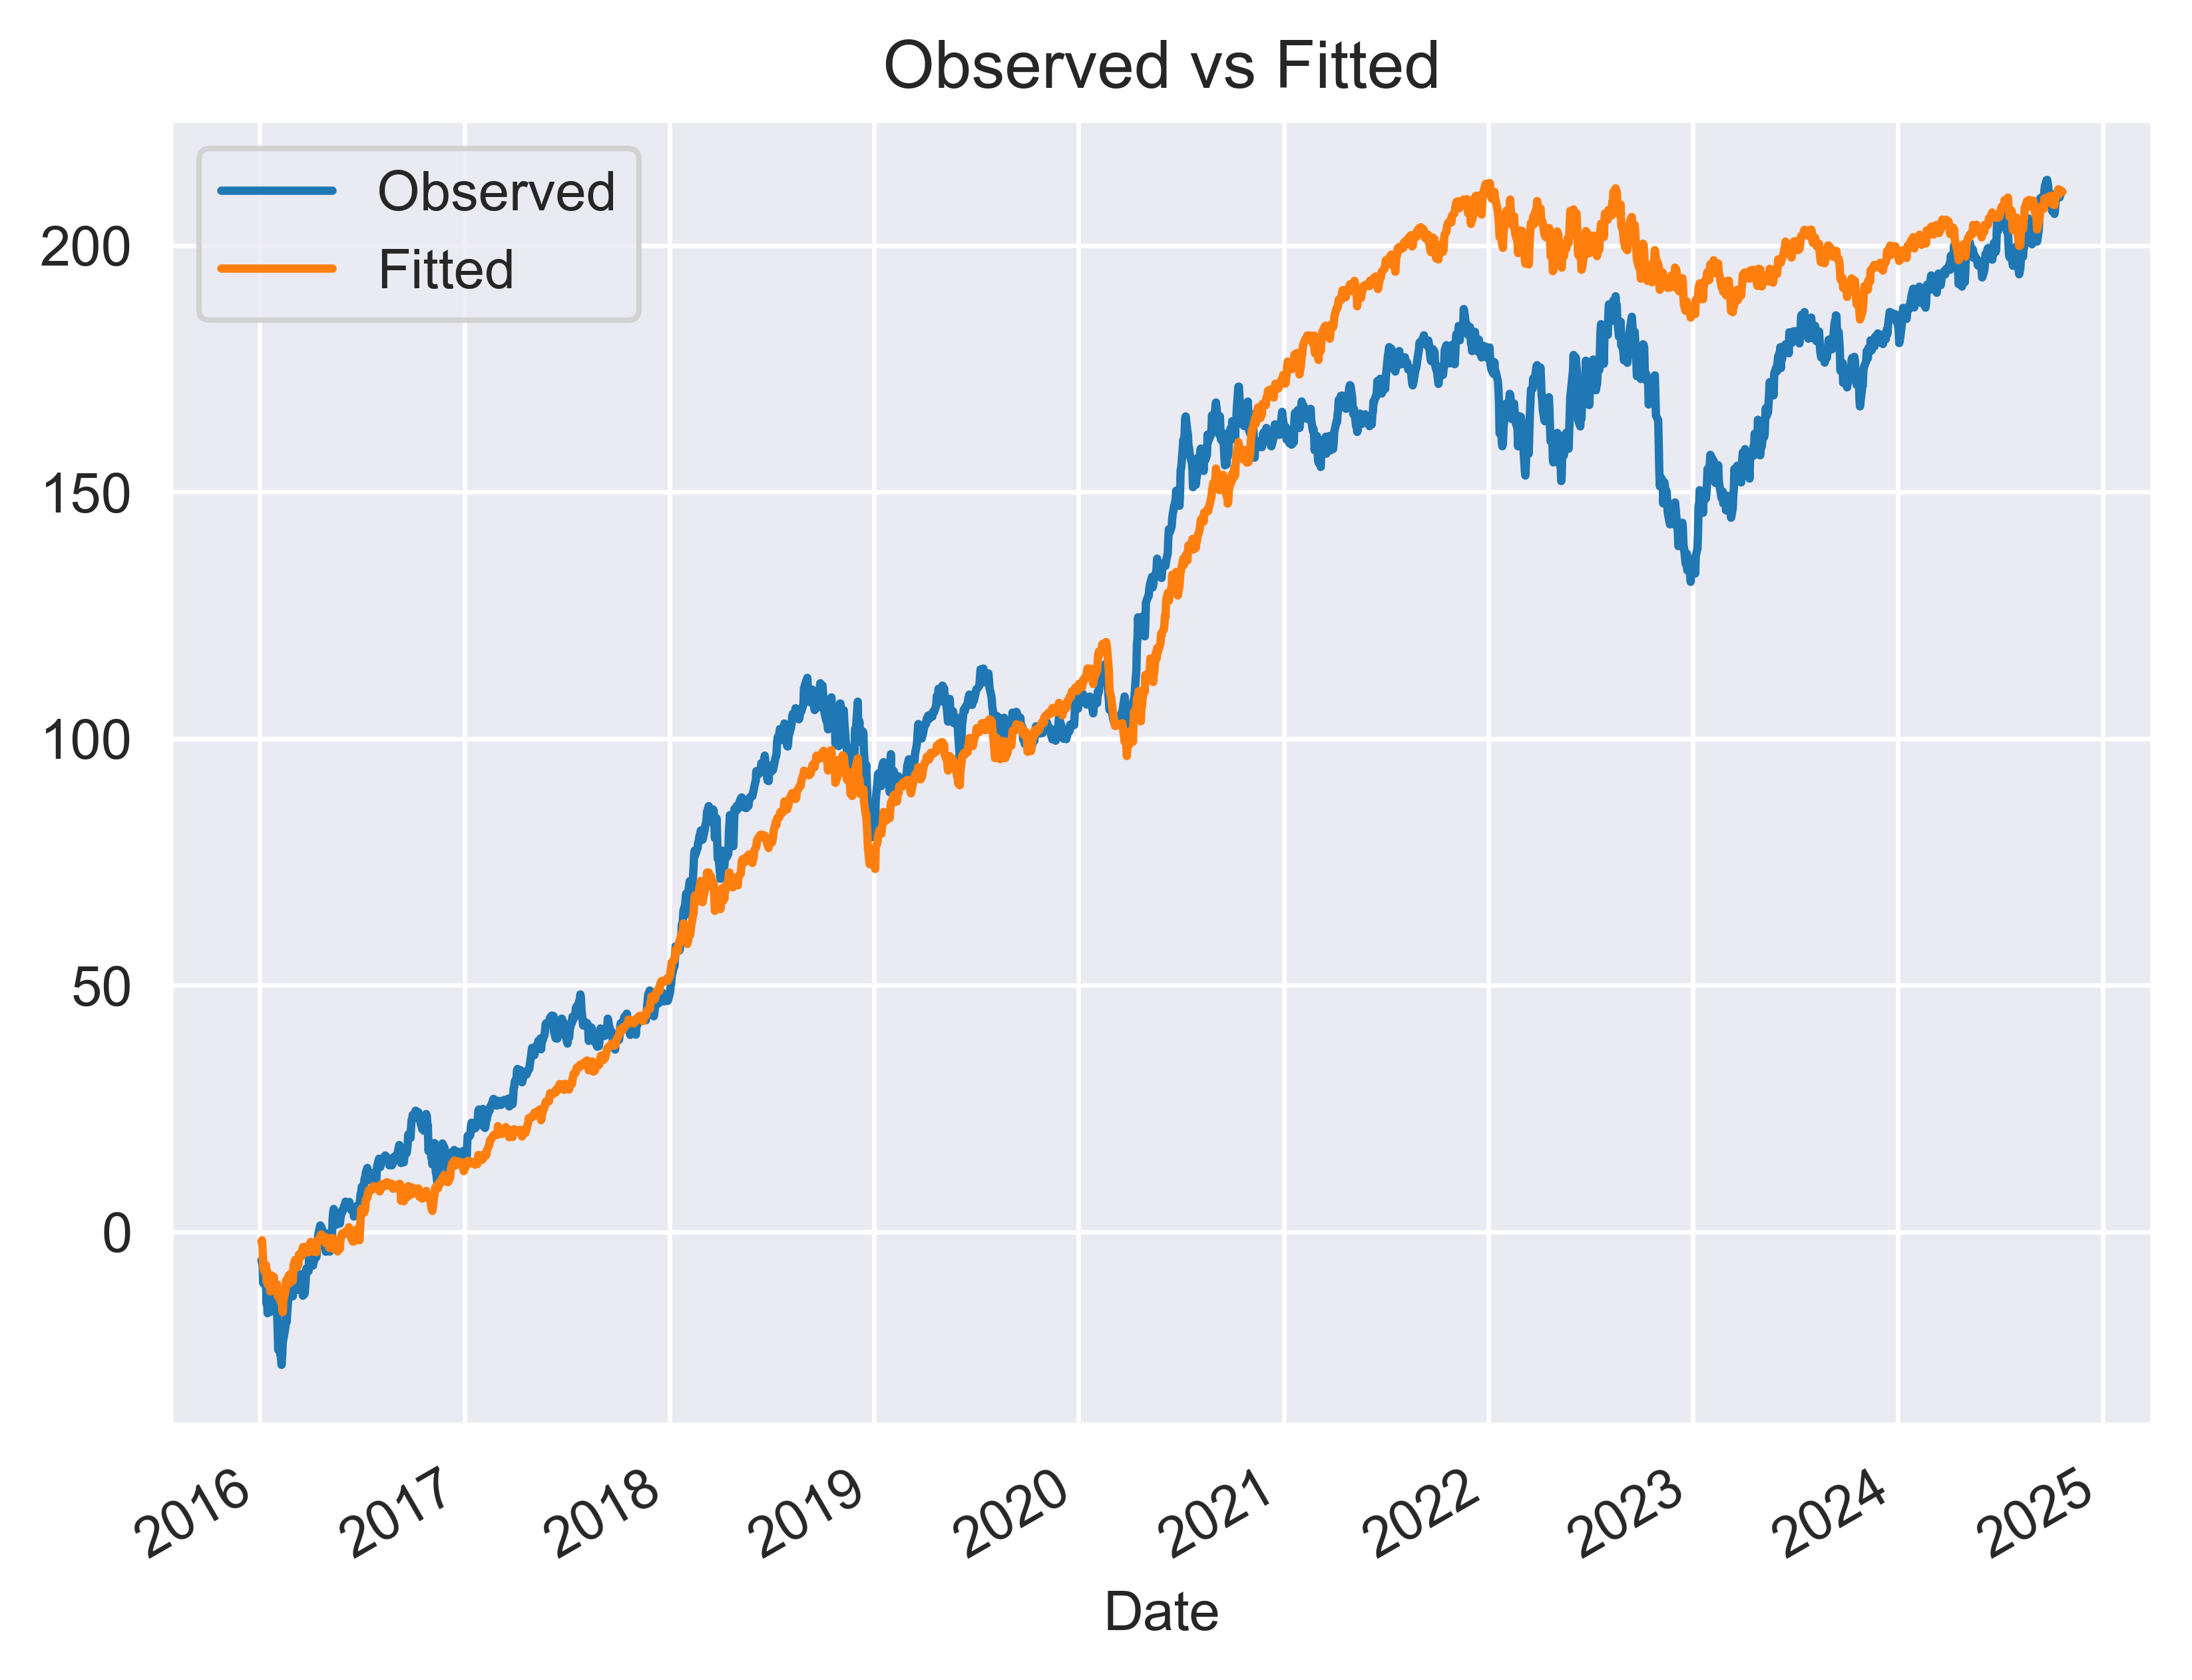

In [166]:
fig, ax1 = plt.subplots(dpi = 600)

filtered_data['expected_returns'] = Y_Hat

filtered_data['returns'].cumsum().plot(label = 'Observed')
filtered_data['expected_returns'].cumsum().plot(label = 'Fitted')
plt.legend()
plt.title('Observed vs Fitted')

plt.show()

In [167]:
# We can obtain the Hat Matrix which is a matrix used to transform the real values into the fitted values

Some_Matrix = Information_Matrix.dot(X_Variance_Matrix_Inverse)
Hat_Matrix = Some_Matrix.to_numpy() @ Information_Matrix_T.to_numpy()

Hat_Matrix

array([[ 0.00484554,  0.00333512,  0.0047643 , ..., -0.00097974,
        -0.00137229, -0.00087427],
       [ 0.00333512,  0.003494  ,  0.00347411, ..., -0.00102186,
        -0.00101675, -0.00107709],
       [ 0.0047643 ,  0.00347411,  0.0047258 , ..., -0.00095567,
        -0.00129869, -0.00087419],
       ...,
       [-0.00097974, -0.00102186, -0.00095567, ...,  0.00262172,
         0.00260342,  0.00262724],
       [-0.00137229, -0.00101675, -0.00129869, ...,  0.00260342,
         0.0026808 ,  0.00257159],
       [-0.00087427, -0.00107709, -0.00087419, ...,  0.00262724,
         0.00257159,  0.00264918]])

In [168]:
print(Information_Matrix.shape)
print(X_Variance_Matrix_Inverse.shape)
print(Some_Matrix.shape)
print(Information_Matrix_T.shape)

(2159, 6)
(6, 6)
(2159, 6)
(6, 2159)


In [169]:
# Let us check if this is true
Y_Hat_2 = Hat_Matrix.dot(Y_Vector)

Y_Hat_2

array([-1.94259637,  0.26041121, -1.67044256, ..., -0.10097806,
        0.42850462, -0.30902315])

In [170]:
# Hat Matrix is Symmetric and Idempotent

Hat_Matrix_Square = (Hat_Matrix.transpose()).dot(Hat_Matrix)

if Hat_Matrix.all() == Hat_Matrix_Square.all():
    print("It is indeed idempotent")
else:
    print("Wrong!")

It is indeed idempotent


In [171]:
# We can calculate the residuals using the Hat Matrix

Identity_Matrix = np.identity(len(Y_Vector))
Residuals_Vector = (Identity_Matrix - Hat_Matrix).dot(Y_Vector)

print(f"The Residuals Mean is: {Residuals_Vector.mean().round(3)}")
print(f"The Residuals Variance is: {Residuals_Vector.var()}")

The Residuals Mean is: -0.0
The Residuals Variance is: 1.6723077282502423


In [172]:
# Residual Returns
filtered_data['residuals'] = Residuals_Vector

filtered_data

returns  mkt_returns  log_mktcap  annualized_volat        ptb  \
Date                                                                         
2016-01-04 -5.755374    -1.530373   26.391673         34.105853  24.034458   
2016-01-05 -0.502363     0.201223   26.391916         34.033236  23.913718   
2016-01-06 -0.179870    -1.311540   26.331750         33.936779  23.870704   
2016-01-07 -3.905793    -2.370044   26.350800         34.191133  22.938364   
2016-01-08 -0.146396    -1.083837   26.311558         34.191983  22.904783   
...              ...          ...         ...               ...        ...   
2024-10-15  0.079983    -0.760947   28.319663         27.849236   8.326890   
2024-10-16 -0.426235     0.467915   28.293006         27.785351   8.291398   
2024-10-17  0.342447    -0.017116   28.302006         27.769032   8.319791   
2024-10-18  0.778542     0.397155   28.309756         27.643488   8.384564   
2024-10-21  0.042330    -0.182277   28.312733         27.643748   8.388114   

            squared_volat  expected_returns  residuals  
Date                                                    
2016-01-04    1163.209210         -1.942596  -3.812778  
2016-01-05    1158.261176          0.260411  -0.762774  
2016-01-06    1151.704937         -1.670443   1.490572  
2016-01-07    1169.033571         -3.029768  -0.876025  
2016-01-08    1169.091693         -1.395146   1.248750  
...                   ...               ...        ...  
2024-10-15     775.579946         -1.047169   1.127152  
2024-10-16     772.025749          0.515527  -0.941762  
2024-10-17     771.119160         -0.100978   0.443425  
2024-10-18     764.162429          0.428505   0.350037  
2024-10-21     764.176829         -0.309023   0.351353  

[2159 rows x 8 columns]

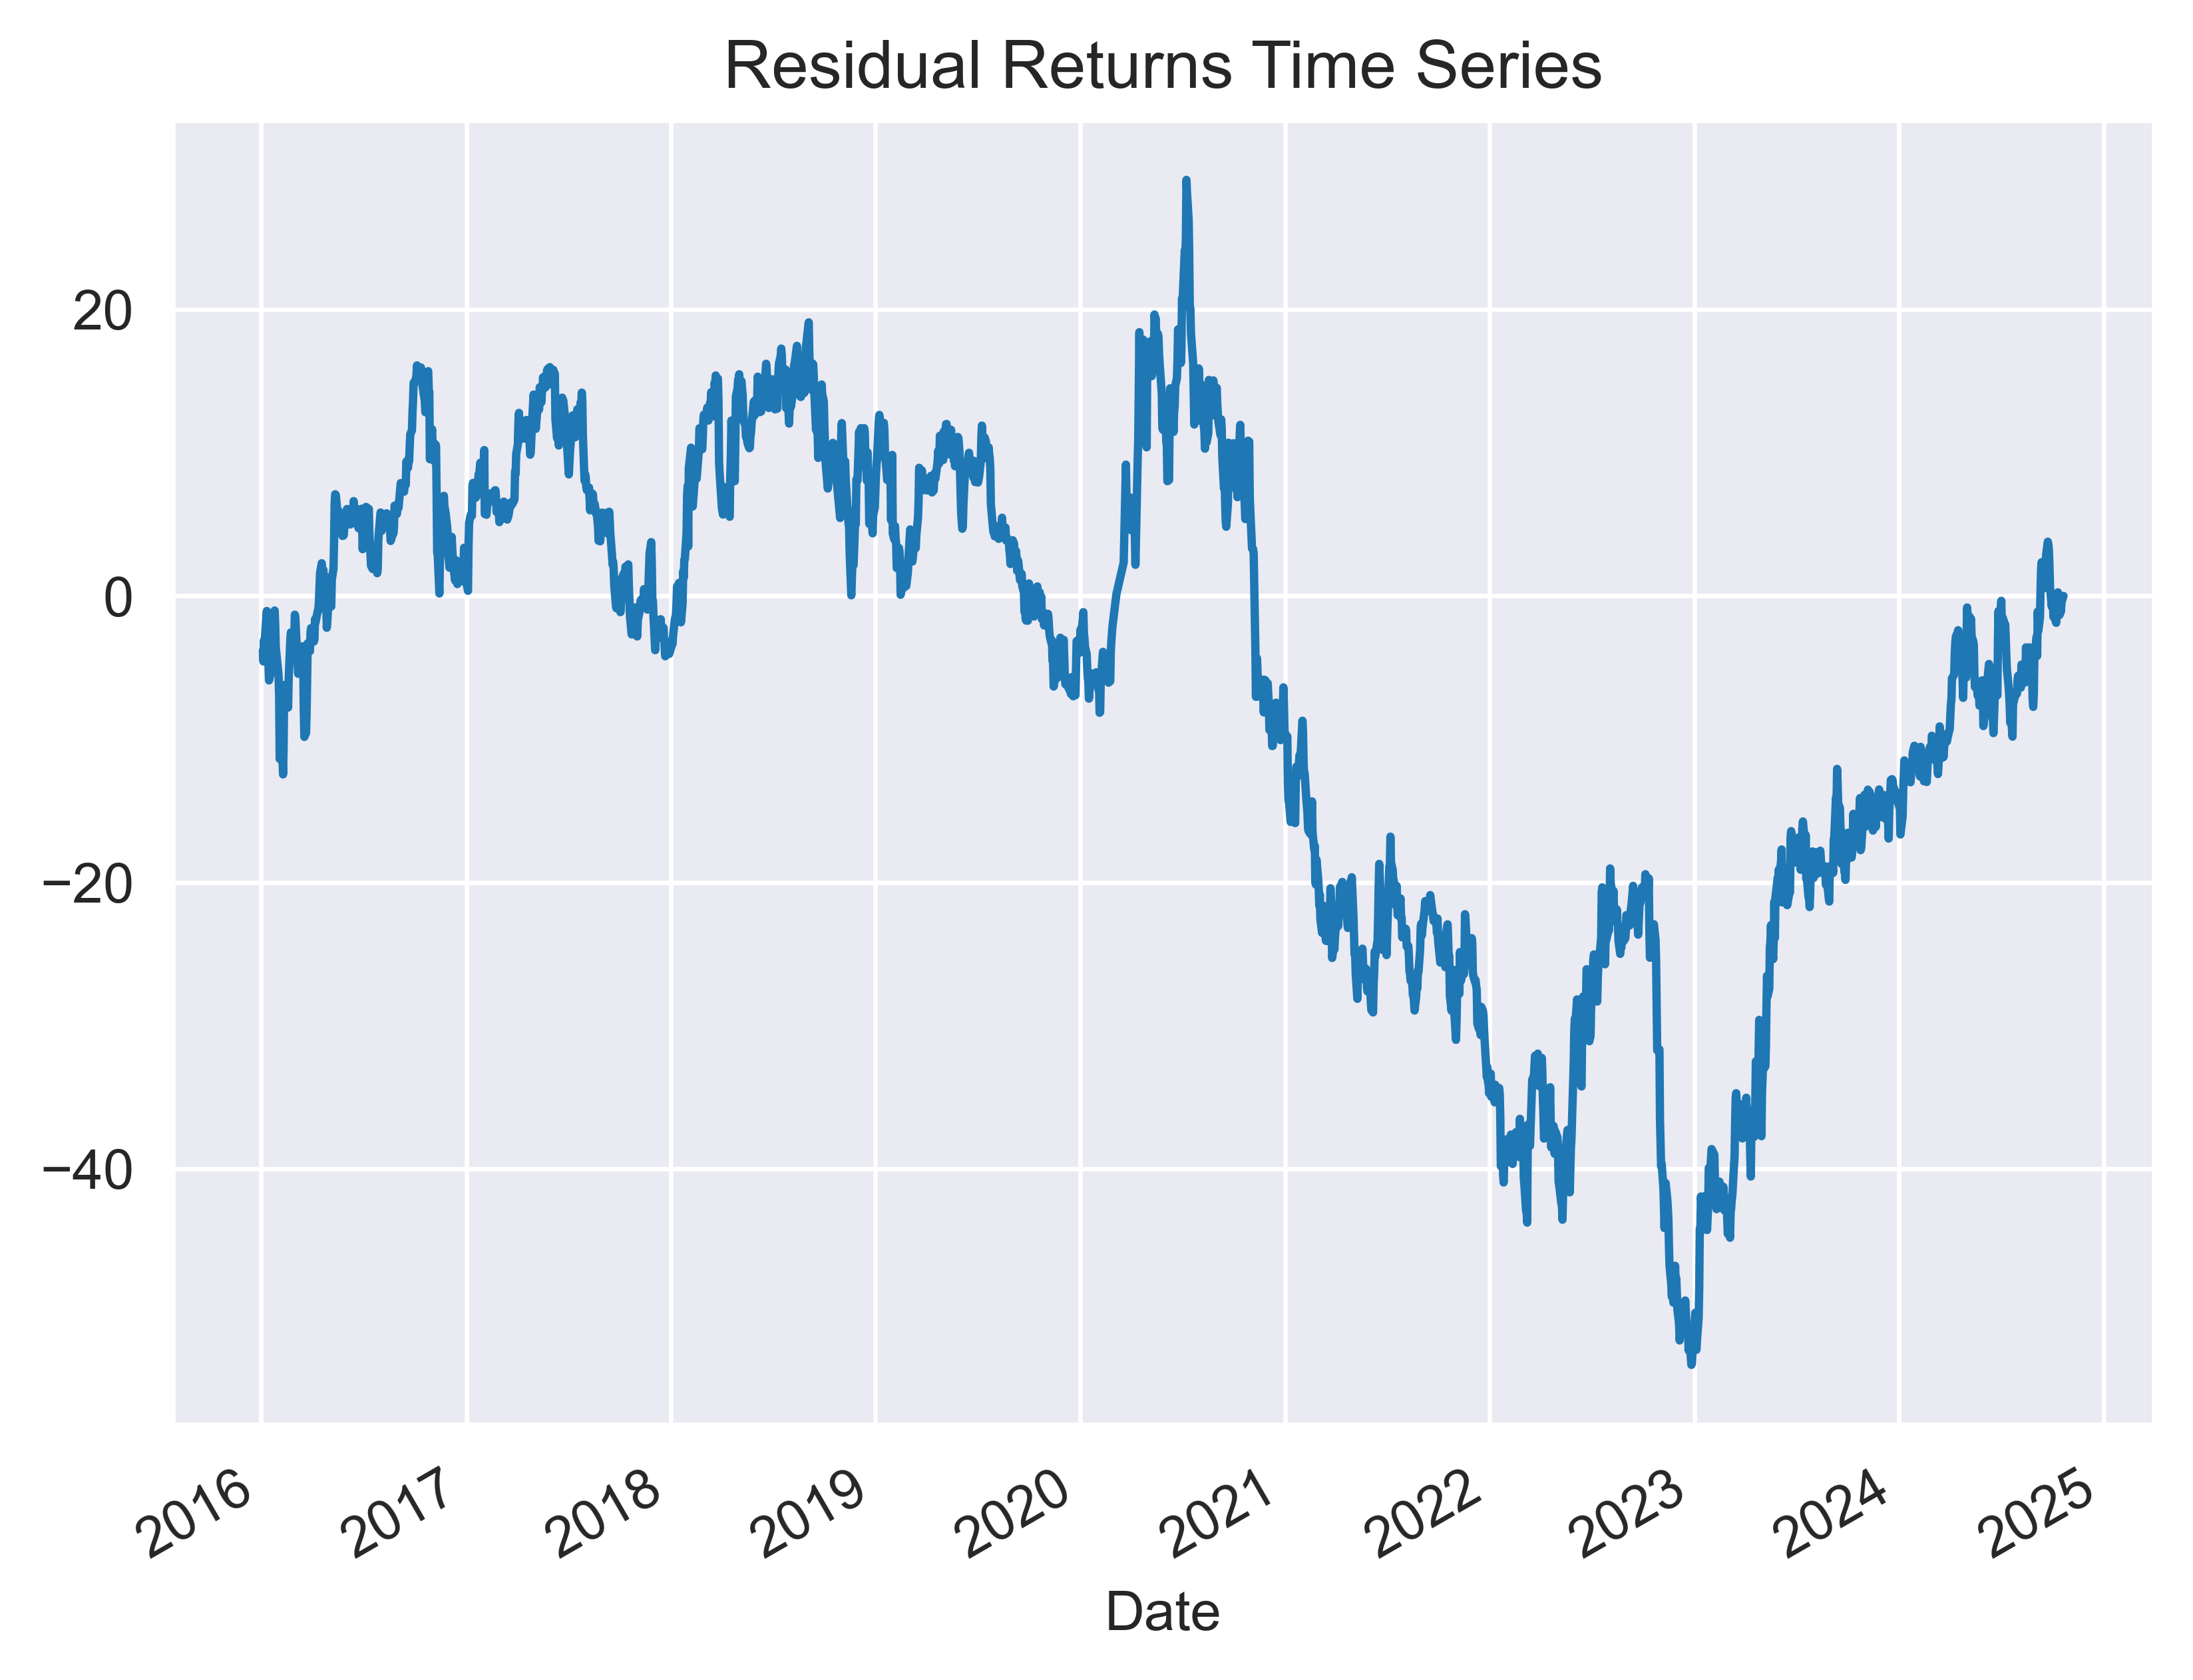

In [173]:
# Plot
fig, ax1 = plt.subplots(dpi = 600)
filtered_data['residuals'].cumsum().plot()
plt.title('Residual Returns Time Series')
plt.show()

In [174]:
# The OLS Assumptions establish that the covariates and the residuals must be uncorrelated

Intercorrelation_Vector = Information_Matrix_T.dot(Residuals_Vector)

print(Intercorrelation_Vector.round(5))

const              -0.0
mkt_returns        -0.0
log_mktcap         -0.0
annualized_volat   -0.0
ptb                -0.0
squared_volat      -0.0
dtype: float64


In [175]:
# We can use this to calculate the Bias of the Beta coefficients

display(Math(r"S=(X^⊤X)^{-1}(X^⊤\varepsilon)"))

Bias = X_Variance_Matrix_Inverse.dot(Intercorrelation_Vector)

print("""
Biases are very close to zero.
""")
print(Bias)

<IPython.core.display.Math object>


Biases are very close to zero.

[ 1.54492037e-12  1.35571512e-15 -5.99163284e-14  1.20336617e-14
 -4.46564799e-15 -1.97610691e-16]


In [176]:
# Now we want to calculate the sum of squares

display(Math(r"RSS=\varepsilon^⊤\varepsilon=Y^⊤Y-\beta^⊤X^⊤Y"))
display(Math(r"ESS=\beta^⊤X^⊤Y-\bar{Y}^2"))
display(Math(r"TSS=Y^⊤Y-\bar{Y}^2"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [177]:
RSS = (Residuals_Vector.transpose()).dot(Residuals_Vector)
ESS = (Beta.transpose()).dot(Y_Covariance_X) - (sum(Y_Vector)**2)/len(Y_Vector)
TSS = (Y_Vector.transpose()).dot(Y_Vector) - (sum(Y_Vector)**2)/len(Y_Vector)

print(f"The Residuals Sum of Squares is: {RSS}")
print(f"The Estimation Sum of Squares is: {ESS}")
print(f"The Total Sum of Squares is: {TSS}")

The Residuals Sum of Squares is: 3610.5123852922734
The Estimation Sum of Squares is: 2945.2970567193597
The Total Sum of Squares is: 6555.809442011638


In [178]:
# We can calculate the R-Squared Coefficient

R_Squared = ESS/TSS

print(f"The R-Squared Coefficient is: {R_Squared}")

The R-Squared Coefficient is: 0.44926520253090224


In [179]:
# Now calculate the Residuals Variance with n - k degrees of freedom (adjusted to the sample)

Residuals_Variance = RSS/(len(Y_Vector) - Hat_Matrix.trace())

print(f"The Residuals Variance is: {Residuals_Variance}")

The Residuals Variance is: 1.676968130651312


In [180]:
# We use the Residuals Variance to calculate the covariances between all the beta coefficients

display(Math(r"C=\frac{\varepsilon^⊤\varepsilon}{n-k}(X^⊤X)^{-1}"))

<IPython.core.display.Math object>

In [181]:
# The Diagonal of the Covariance Matrix contains the standard errors of the beta coefficients

Covariance_Matrix = (Residuals_Variance)*X_Variance_Matrix_Inverse

Covariance_Matrix

array([[ 3.11769961e+00,  2.60023640e-03, -1.10649710e-01,
         5.54327770e-03, -7.48317554e-03, -1.09808252e-04],
       [ 2.60023640e-03,  9.31928870e-04, -8.82426949e-05,
        -3.75605526e-06, -8.52235782e-06,  2.55085446e-08],
       [-1.10649710e-01, -8.82426949e-05,  4.16229888e-03,
        -5.82952229e-04,  2.63079669e-04,  9.38867329e-06],
       [ 5.54327770e-03, -3.75605526e-06, -5.82952229e-04,
         7.18168993e-04, -4.96454148e-05, -1.07446416e-05],
       [-7.48317554e-03, -8.52235782e-06,  2.63079669e-04,
        -4.96454148e-05,  4.60649859e-05,  9.72540934e-07],
       [-1.09808252e-04,  2.55085446e-08,  9.38867329e-06,
        -1.07446416e-05,  9.72540934e-07,  1.65056735e-07]])

In [182]:
# Take the squared-root

Beta_Standards_Errors = np.sqrt(Covariance_Matrix.diagonal())

Beta_Standards_Errors

array([1.76570088e+00, 3.05275101e-02, 6.45158809e-02, 2.67986752e-02,
       6.78711912e-03, 4.06271750e-04])

In [183]:
# Calculate the T-Values

T_Values = Beta/Beta_Standards_Errors

T_Values

array([-0.89696305, 41.70891994,  1.02439269, -1.12907   ,  2.07798008,
        1.13954491])

In [184]:
# How much degrees of freedom we have?

df = len(Y_Vector) - Hat_Matrix.trace()

print(f"We have {df.round()} degrees of freedom.")

We have 2153.0 degrees of freedom.


In [185]:
# The Hypothesis Testing implies to reject the null hypothesis if the t-values are higher than the critic t-value
# For 293 degrees of freedom the critic t-value approaches to 1.96
# Then we can calculate the upper and lower limits

Beta_Lower_Limit = Beta - 1.96*Beta_Standards_Errors
Beta_Upper_Limit = Beta + 1.96*Beta_Standards_Errors

print(Beta_Lower_Limit)
print(Beta_Upper_Limit)

[-5.04454218e+00  1.21343555e+00 -6.03615298e-02 -8.27829837e-02
  8.00744887e-04 -3.33327727e-04]
[1.87700529e+00 1.33310339e+00 1.92540723e-01 2.22678231e-02
 2.74062518e-02 1.25925753e-03]


In [186]:
# We can build a dataframe that contains all the information

Proof_DF = pd.DataFrame(
    {
     "T_Values": T_Values, 
     "Beta_Inferior_Limit": Beta_Lower_Limit, 
     "Beta_Superior_Limit": Beta_Upper_Limit
     }
    )

print(Proof_DF)

    T_Values  Beta_Inferior_Limit  Beta_Superior_Limit
0  -0.896963            -5.044542             1.877005
1  41.708920             1.213436             1.333103
2   1.024393            -0.060362             0.192541
3  -1.129070            -0.082783             0.022268
4   2.077980             0.000801             0.027406
5   1.139545            -0.000333             0.001259


In [187]:
# Let us obtain the p-values, if these are less than 0.05, we reject the null hypothesis confirming statistically significance

Proof_DF["p-values"] = 2*(t.sf(
    abs(Proof_DF.T_Values), 
    len(Y_Vector) - Hat_Matrix.trace()
    ).round(3)
    )

print(Proof_DF)

    T_Values  Beta_Inferior_Limit  Beta_Superior_Limit  p-values
0  -0.896963            -5.044542             1.877005     0.370
1  41.708920             1.213436             1.333103     0.000
2   1.024393            -0.060362             0.192541     0.306
3  -1.129070            -0.082783             0.022268     0.258
4   2.077980             0.000801             0.027406     0.038
5   1.139545            -0.000333             0.001259     0.254


In [188]:
"""
The R-Squared is not always the most precise staitstic in a multilinear model
The Adjusted R-Squared penalizes the existence of more variables in our model:
    
    Adjusted R Squared = 1 – [((1 – R2) * (n – 1)) / (n – k)]
    
"""

R_Squared_Adjusted = (1 - ((1-R_Squared)*(len(Y_Vector) - 1)/(len(Y_Vector) - Hat_Matrix.trace())))

print(f"The Adjusted R-Squared is: {R_Squared_Adjusted.round(5)}")

The Adjusted R-Squared is: 0.44799


In [189]:
"""
The F Statistic  help us to prove Joint Significance.
This means taht we are checking if our models as a whole can explain the Y

The F statistic is distributed in a F distribution with n - k and
k - 1 degrees of freedom.
"""

display(Math(r"F=\frac{ESS/k-1}{RSS/n-k}"))


<IPython.core.display.Math object>

In [190]:
# Calculate the F Stat

F_Stat = (ESS/(Hat_Matrix.trace() - 1)) / (RSS/(len(Y_Vector) - Hat_Matrix.trace()))

print(f"The F-Statistic is: {F_Stat}")

The F-Statistic is: 351.26452350349695


In [191]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(Information_Matrix)
    )   
     
#the results of the model
results = model.fit() 
    
#The Parameters
Beta2 = results.params  

#here we check the summary
print(results.summary())       

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     351.3
Date:                Tue, 15 Apr 2025   Prob (F-statistic):          1.07e-275
Time:                        22:36:21   Log-Likelihood:                -3618.6
No. Observations:                2159   AIC:                             7249.
Df Residuals:                    2153   BIC:                             7283.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.5838      1.766  

In [192]:
Beta

array([-1.58376845e+00,  1.27326947e+00,  6.60895967e-02, -3.02575803e-02,
        1.41034984e-02,  4.62964903e-04])

In [193]:
# Calculate the VIF

X = Information_Matrix

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

vars          VIF
0             const  4013.858902
1       mkt_returns     1.002864
2        log_mktcap     1.712818
3  annualized_volat    53.574265
4               ptb     2.237423
5     squared_volat    55.894276

In [194]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = X.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

vars  r_squared
0             const   0.999751
1       mkt_returns   0.002856
2        log_mktcap   0.416167
3  annualized_volat   0.981334
4               ptb   0.553057
5     squared_volat   0.982109

In [195]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(X.drop(['annualized_volat', 'squared_volat'], axis=1))
    )   
     
#the results of the model
results = model.fit() 

#here we check the summary
print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     585.2
Date:                Tue, 15 Apr 2025   Prob (F-statistic):          3.49e-278
Time:                        22:36:21   Log-Likelihood:                -3619.2
No. Observations:                2159   AIC:                             7246.
Df Residuals:                    2155   BIC:                             7269.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2861      1.705     -0.754      

In [196]:
# Calculate the VIF

X = Information_Matrix.drop(['annualized_volat', 'squared_volat'], axis=1)

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

vars          VIF
0        const  3742.755948
1  mkt_returns     1.002608
2   log_mktcap     1.475559
3          ptb     1.474912